## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['25 hPa'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['25 hPa'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['25 hPa'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['25 hPa'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['25 hPa'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['25 hPa'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['25 hPa'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['25 hPa'] - data_df['25 hPa'].shift(lag)) / data_df['25 hPa'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['25 hPa'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['25 hPa'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['25 hPa'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['25 hPa'] - data_df['25 hPa'].mean()) / data_df['25 hPa'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['25 hPa'].median()
    mad = np.median(np.abs(data_df['25 hPa'] - median))
    data_df['mad_z_score'] = (data_df['25 hPa'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['25 hPa'] / data_df['25 hPa'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-10,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-10,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-10,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-10,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-10,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-10,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-10,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-10,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-01-11,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', 'rolling_min_2', '20 hPa',
       'rolling_min_3', 'moving_average_2', 'mad_z_score', 'rolling_max_3',
       'z_score', 'interaction_ma_ema_2', 'moving_average_3', 'lag_1',
       'moving_median_2', 'lag_2', 'lag_3', 'ema_12', 'interaction_ma_ema_3',
       'ema_3'],
      dtype='object')


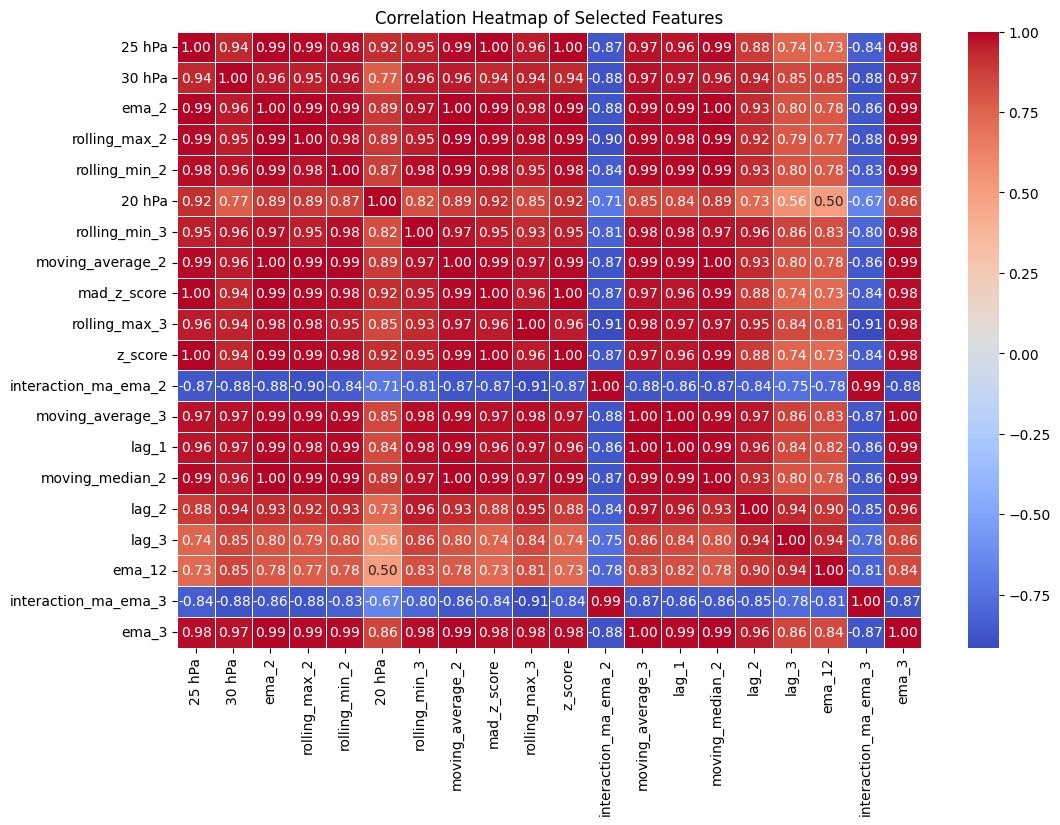

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.1, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(292, 28, 20) (292,)

Testing set shapes:
(33, 28, 20) (33,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7246 - mae: 0.7555 - r_squared: -72.7725
Epoch 1: val_loss improved from inf to 0.65807, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.7174 - mae: 0.7497 - r_squared: -70.9187 - val_loss: 0.6581 - val_mae: 0.7013 - val_r_squared: -37.6589
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4244 - mae: 0.5389 - r_squared: -86.3450
Epoch 2: val_loss improved from 0.65807 to 0.54981, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4236 - mae: 0.5369 - r_squared: -84.4047 - val_loss: 0.5498 - val_mae: 0.5809 - val_r_squared: -50.8594
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3436 - mae: 0.4585 - r_squared: -108.5304
Epoch 3: val_loss improved from 0.54981 to 0.31552, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3380 - mae: 0.4550 - r_squared: -105.9175 - val_loss: 0.3155 - val_mae: 0.4663 - val_r_squared: -51.8083
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2274 - mae: 0.3929 - r_squared: -106.8212
Epoch 4: val_loss improved from 0.31552 to 0.25024, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2268 - mae: 0.3917 - r_squared: -104.0380 - val_loss: 0.2502 - val_mae: 0.3992 - val_r_squared: -50.8513
Epoch 5/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1867 - mae: 0.3324 - r_squared: -110.1279
Epoch 5: val_loss improved from 0.25024 to 0.23362, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1815 - mae: 0.3284 - r_squared: -103.4711 - val_loss: 0.2336 - val_mae: 0.3598 - val_r_squared: -56.9598
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1451 - mae: 0.2829 - r_squared: -117.0302
Epoch 6: val_loss improved from 0.23362 to 0.18588, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1467 - mae: 0.2851 - r_squared: -113.9709 - val_loss: 0.1859 - val_mae: 0.3323 - val_r_squared: -58.3256
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1440 - mae: 0.2836 - r_squared: -114.7809
Epoch 7: val_loss improved from 0.18588 to 0.15920, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1437 - mae: 0.2835 - r_squared: -111.7507 - val_loss: 0.1592 - val_mae: 0.2993 - val_r_squared: -55.9096
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1363 - mae: 0.2708 - r_squared: -112.6744
Epoch 8: val_loss did not improve from 0.15920
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1345 - mae: 0.2684 - r_squared: -110.0813 - val_loss: 0.1712 - val_mae: 0.2930 - val_r_squared: -56.8830
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1201 - mae: 0.2476 - r_squared: -114.6496
Epoch 9: val_loss improved from 0.15920 to 0.13016, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1197 - mae: 0.2465 - r_squared: -111.9430 - val_loss: 0.1302 - val_mae: 0.2625 - val_r_squared: -55.7353
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1031 - mae: 0.2357 - r_squared: -113.5959
Epoch 10: val_loss did not improve from 0.13016
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1044 - mae: 0.2362 - r_squared: -110.6355 - val_loss: 0.1359 - val_mae: 0.2473 - val_r_squared: -55.7076
Epoch 11/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1044 - mae: 0.2296 - r_squared: -118.0770
Epoch 11: val_loss improved from 0.13016 to 0.09253, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1042 - mae: 0.2295 - r_squared: -110.7147 - val_loss: 0.0925 - val_mae: 0.2294 - val_r_squared: -55.9323
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1086 - mae: 0.2323 - r_squared: -112.9075
Epoch 12: val_loss did not improve from 0.09253
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1087 - mae: 0.2336 - r_squared: -110.0127 - val_loss: 0.1165 - val_mae: 0.2335 - val_r_squared: -58.3202
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1023 - mae: 0.2237 - r_squared: -120.0123
Epoch 13: val_loss did not improve from 0.09253
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1008 - mae: 0.2229 - r_squared: -116.7418 - val_loss: 0.0964 - val_mae: 0.2304 - val_r_squared: -59.8822
Epoch 14/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0865 - mae: 0.2069 - r_squared: -121.1381
Epoch 14: val_loss did not improve from 0.09253
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0880 - mae: 0.2081 - r_squared: -118.286

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1077 - mae: 0.2374 - r_squared: -113.4777 - val_loss: 0.0844 - val_mae: 0.2233 - val_r_squared: -54.8003
Epoch 16/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1187 - mae: 0.2578 - r_squared: -112.7485 
Epoch 16: val_loss did not improve from 0.08438
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1114 - mae: 0.2488 - r_squared: -106.8184 - val_loss: 0.1890 - val_mae: 0.2919 - val_r_squared: -61.8673
Epoch 17/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1127 - mae: 0.2202 - r_squared: -124.8537
Epoch 17: val_loss did not improve from 0.08438
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1118 - mae: 0.2196 - r_squared: -121.3529 - val_loss: 0.1021 - val_mae: 0.2321 - val_r_squared: -55.4290
Epoch 18/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0542 - mae: 0.1759 - r_squared: -117.1566
Epoch 18: val_loss did not improve from 0.08438
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0780 - mae: 0.2059 - r_squared: -107.62

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0821 - mae: 0.1962 - r_squared: -112.2056 - val_loss: 0.0822 - val_mae: 0.2126 - val_r_squared: -55.0493
Epoch 23/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0897 - mae: 0.2156 - r_squared: -109.7669
Epoch 23: val_loss improved from 0.08219 to 0.07788, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0880 - mae: 0.2134 - r_squared: -107.4325 - val_loss: 0.0779 - val_mae: 0.2040 - val_r_squared: -59.3017
Epoch 24/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0708 - mae: 0.1704 - r_squared: -120.3206
Epoch 24: val_loss improved from 0.07788 to 0.06404, saving model to best_model_lstm.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0728 - mae: 0.1730 - r_squared: -117.3447 - val_loss: 0.0640 - val_mae: 0.2024 - val_r_squared: -61.2806
Epoch 25/200
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0624 - mae: 0.1766 - r_squared: -125.0222
Epoch 25: val_loss did not improve from 0.06404
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0703 - mae: 0.1849 - r_squared: -115.8833 - val_loss: 0.1058 - val_mae: 0.2392 - val_r_squared: -60.1407
Epoch 26/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0928 - mae: 0.2242 - r_squared: -118.6864
Epoch 26: val_loss did not improve from 0.06404
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0914 - mae: 0.2224 - r_squared: -115.7758 - val_loss: 0.0892 - val_mae: 0.2217 - val_r_squared: -58.8605
Epoch 27/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0762 - mae: 0.1901 - r_squared: -117.6614
Epoch 27: val_loss did not improve from 0.06404
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0775 - mae: 0.1909 - r_squared: -114.578

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0694 - mae: 0.1915 - r_squared: -111.2645 - val_loss: 0.0573 - val_mae: 0.1894 - val_r_squared: -57.5149
Epoch 61/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0679 - mae: 0.1850 - r_squared: -115.5036
Epoch 61: val_loss did not improve from 0.05735
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0685 - mae: 0.1841 - r_squared: -110.8384 - val_loss: 0.0904 - val_mae: 0.2159 - val_r_squared: -60.9522
Epoch 62/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0583 - mae: 0.1687 - r_squared: -119.3213
Epoch 62: val_loss did not improve from 0.05735
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0589 - mae: 0.1691 - r_squared: -116.2543 - val_loss: 0.0591 - val_mae: 0.1802 - val_r_squared: -59.7152
Epoch 63/200
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0417 - mae: 0.1391 - r_squared: -121.2410
Epoch 63: val_loss did not improve from 0.05735
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0516 - mae: 0.1526 - r_squared: -114.891

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0684 - mae: 0.1665 - r_squared: -120.5240 - val_loss: 0.0572 - val_mae: 0.1765 - val_r_squared: -59.6683
Epoch 124/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0584 - mae: 0.1440 - r_squared: -122.1640
Epoch 124: val_loss did not improve from 0.05722
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0581 - mae: 0.1461 - r_squared: -114.4114 - val_loss: 0.1004 - val_mae: 0.2305 - val_r_squared: -57.6467
Epoch 125/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0641 - mae: 0.1935 - r_squared: -113.8025
Epoch 125: val_loss did not improve from 0.05722
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0645 - mae: 0.1933 - r_squared: -110.9708 - val_loss: 0.0831 - val_mae: 0.2155 - val_r_squared: -60.9517
Epoch 126/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0613 - mae: 0.1603 - r_squared: -121.6095 
Epoch 126: val_loss did not improve from 0.05722
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0601 - mae: 0.1591 - r_squared: -

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.0214 - mae: 0.9195 - r_squared: -71.1458
Epoch 1: val_loss improved from inf to 0.63627, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 961ms/step - loss: 0.9688 - mae: 0.8914 - r_squared: -67.5107 - val_loss: 0.6363 - val_mae: 0.5488 - val_r_squared: -50.4692
Epoch 2/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4709 - mae: 0.5309 - r_squared: -109.8533
Epoch 2: val_loss improved from 0.63627 to 0.59471, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.4809 - mae: 0.5345 - r_squared: -105.0837 - val_loss: 0.5947 - val_mae: 0.5701 - val_r_squared: -56.6119
Epoch 3/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4724 - mae: 0.5142 - r_squared: -123.2828
Epoch 3: val_loss improved from 0.59471 to 0.44751, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.4591 - mae: 0.5126 - r_squared: -113.8750 - val_loss: 0.4475 - val_mae: 0.5319 - val_r_squared: -44.0184
Epoch 4/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3305 - mae: 0.4678 - r_squared: -97.0194
Epoch 4: val_loss improved from 0.44751 to 0.38402, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 0.3295 - mae: 0.4669 - r_squared: -90.8868 - val_loss: 0.3840 - val_mae: 0.4858 - val_r_squared: -43.4236
Epoch 5/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.3045 - mae: 0.4326 - r_squared: -99.7290
Epoch 5: val_loss improved from 0.38402 to 0.30136, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.3067 - mae: 0.4332 - r_squared: -94.0673 - val_loss: 0.3014 - val_mae: 0.4267 - val_r_squared: -48.9662
Epoch 6/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2659 - mae: 0.4047 - r_squared: -111.4498
Epoch 6: val_loss improved from 0.30136 to 0.28184, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 0.2660 - mae: 0.4048 - r_squared: -104.7435 - val_loss: 0.2818 - val_mae: 0.4076 - val_r_squared: -53.3182
Epoch 7/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2466 - mae: 0.3789 - r_squared: -115.1924
Epoch 7: val_loss did not improve from 0.28184
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.2459 - mae: 0.3770 - r_squared: -107.9057 - val_loss: 0.2970 - val_mae: 0.3768 - val_r_squared: -52.4704
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2313 - mae: 0.3620 - r_squared: -108.3451
Epoch 8: val_loss improved from 0.28184 to 0.27002, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - loss: 0.2328 - mae: 0.3626 - r_squared: -105.4952 - val_loss: 0.2700 - val_mae: 0.3672 - val_r_squared: -53.2679
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2179 - mae: 0.3625 - r_squared: -111.0256
Epoch 9: val_loss improved from 0.27002 to 0.25351, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.2195 - mae: 0.3635 - r_squared: -108.3830 - val_loss: 0.2535 - val_mae: 0.3773 - val_r_squared: -55.5517
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2185 - mae: 0.3602 - r_squared: -115.1754
Epoch 10: val_loss improved from 0.25351 to 0.24884, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - loss: 0.2203 - mae: 0.3615 - r_squared: -112.4957 - val_loss: 0.2488 - val_mae: 0.3569 - val_r_squared: -53.5637
Epoch 11/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1819 - mae: 0.3350 - r_squared: -114.9260
Epoch 11: val_loss improved from 0.24884 to 0.23793, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - loss: 0.1896 - mae: 0.3420 - r_squared: -107.8709 - val_loss: 0.2379 - val_mae: 0.3421 - val_r_squared: -52.7832
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1872 - mae: 0.3327 - r_squared: -113.2552 
Epoch 12: val_loss improved from 0.23793 to 0.21189, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - loss: 0.1897 - mae: 0.3349 - r_squared: -109.9725 - val_loss: 0.2119 - val_mae: 0.3318 - val_r_squared: -52.8508
Epoch 13/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1813 - mae: 0.3192 - r_squared: -117.5790
Epoch 13: val_loss improved from 0.21189 to 0.20322, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 0.1864 - mae: 0.3250 - r_squared: -110.1800 - val_loss: 0.2032 - val_mae: 0.3318 - val_r_squared: -53.2826
Epoch 14/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1779 - mae: 0.3218 - r_squared: -116.8224
Epoch 14: val_loss improved from 0.20322 to 0.19531, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 0.1833 - mae: 0.3282 - r_squared: -110.0340 - val_loss: 0.1953 - val_mae: 0.3212 - val_r_squared: -53.8692
Epoch 15/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1551 - mae: 0.3019 - r_squared: -121.6207
Epoch 15: val_loss did not improve from 0.19531
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.1546 - mae: 0.3010 - r_squared: -113.8452 - val_loss: 0.2030 - val_mae: 0.3170 - val_r_squared: -53.6909
Epoch 16/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1874 - mae: 0.3285 - r_squared: -117.6520
Epoch 16: val_loss did not improve from 0.19531
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.1793 - mae: 0.3214 - r_squared: -110.9332 - val_loss: 0.1998 - val_mae: 0.3089 - val_r_squared: -55.5053
Epoch 17/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1880 - mae: 0.3185 - r_squared: -115.8295
Epoch 17: val_loss improved from 0.19531 to 0.17018, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 0.1858 - mae: 0.3180 - r_squared: -112.9982 - val_loss: 0.1702 - val_mae: 0.2816 - val_r_squared: -53.6733
Epoch 18/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1455 - mae: 0.2911 - r_squared: -119.5033
Epoch 18: val_loss improved from 0.17018 to 0.14642, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.1518 - mae: 0.2975 - r_squared: -111.5801 - val_loss: 0.1464 - val_mae: 0.2673 - val_r_squared: -52.3304
Epoch 19/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1765 - mae: 0.3268 - r_squared: -112.5997
Epoch 19: val_loss did not improve from 0.14642
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.1704 - mae: 0.3196 - r_squared: -106.5689 - val_loss: 0.1470 - val_mae: 0.2796 - val_r_squared: -57.5574
Epoch 20/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1374 - mae: 0.2931 - r_squared: -122.7618
Epoch 20: val_loss improved from 0.14642 to 0.11098, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 0.1400 - mae: 0.2935 - r_squared: -116.3024 - val_loss: 0.1110 - val_mae: 0.2583 - val_r_squared: -59.8811
Epoch 21/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1791 - mae: 0.3164 - r_squared: -121.4362 
Epoch 21: val_loss improved from 0.11098 to 0.10128, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.1744 - mae: 0.3130 - r_squared: -118.0999 - val_loss: 0.1013 - val_mae: 0.2343 - val_r_squared: -54.6679
Epoch 22/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1515 - mae: 0.3095 - r_squared: -112.9511
Epoch 22: val_loss did not improve from 0.10128
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.1476 - mae: 0.3042 - r_squared: -105.9521 - val_loss: 0.1320 - val_mae: 0.2671 - val_r_squared: -54.0465
Epoch 23/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1204 - mae: 0.2692 - r_squared: -119.9139
Epoch 23: val_loss did not improve from 0.10128
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.1227 - mae: 0.2715 - r_squared: -113.3793 - val_loss: 0.1236 - val_mae: 0.2827 - val_r_squared: -58.8510
Epoch 24/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1313 - mae: 0.2878 - r_squared: -121.7495
Epoch 24: val_loss improved from 0.10128 to 0.08142, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - loss: 0.1318 - mae: 0.2857 - r_squared: -115.0156 - val_loss: 0.0814 - val_mae: 0.2264 - val_r_squared: -57.3697
Epoch 25/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1558 - mae: 0.2979 - r_squared: -115.5613
Epoch 25: val_loss did not improve from 0.08142
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.1514 - mae: 0.2937 - r_squared: -108.1416 - val_loss: 0.1105 - val_mae: 0.2619 - val_r_squared: -56.4437
Epoch 26/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1352 - mae: 0.2887 - r_squared: -116.7088
Epoch 26: val_loss did not improve from 0.08142
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.1316 - mae: 0.2837 - r_squared: -110.0438 - val_loss: 0.1110 - val_mae: 0.2471 - val_r_squared: -57.8772
Epoch 27/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1249 - mae: 0.2718 - r_squared: -123.4240
Epoch 27: val_loss improved from 0.08142 to 0.06472, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.1271 - mae: 0.2717 - r_squared: -116.2674 - val_loss: 0.0647 - val_mae: 0.2064 - val_r_squared: -55.8373
Epoch 28/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1335 - mae: 0.2812 - r_squared: -117.0680
Epoch 28: val_loss did not improve from 0.06472
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.1322 - mae: 0.2813 - r_squared: -109.5844 - val_loss: 0.1107 - val_mae: 0.2559 - val_r_squared: -53.4312
Epoch 29/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1300 - mae: 0.2803 - r_squared: -110.8000
Epoch 29: val_loss did not improve from 0.06472
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.1315 - mae: 0.2816 - r_squared: -105.1951 - val_loss: 0.0822 - val_mae: 0.2237 - val_r_squared: -59.5367
Epoch 30/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1409 - mae: 0.2811 - r_squared: -123.5711
Epoch 30: val_loss did not improve from 0.06472
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.1382 - mae: 0.2812 - r_squared: -117

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0959 - mae: 0.2308 - r_squared: -115.3483 - val_loss: 0.0576 - val_mae: 0.2004 - val_r_squared: -61.2354
Epoch 41/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0974 - mae: 0.2324 - r_squared: -126.6655
Epoch 41: val_loss did not improve from 0.05757
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0999 - mae: 0.2344 - r_squared: -119.3698 - val_loss: 0.0952 - val_mae: 0.2681 - val_r_squared: -65.6449
Epoch 42/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0952 - mae: 0.2411 - r_squared: -127.3690
Epoch 42: val_loss improved from 0.05757 to 0.05230, saving model to best_model_transformer.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.0952 - mae: 0.2389 - r_squared: -120.0874 - val_loss: 0.0523 - val_mae: 0.1934 - val_r_squared: -59.1712
Epoch 43/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1176 - mae: 0.2511 - r_squared: -119.2860
Epoch 43: val_loss did not improve from 0.05230
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.1140 - mae: 0.2490 - r_squared: -111.9413 - val_loss: 0.0638 - val_mae: 0.2078 - val_r_squared: -54.2808
Epoch 44/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0928 - mae: 0.2264 - r_squared: -115.2597
Epoch 44: val_loss did not improve from 0.05230
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0947 - mae: 0.2290 - r_squared: -108.6089 - val_loss: 0.0970 - val_mae: 0.2392 - val_r_squared: -56.9350
Epoch 45/200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0901 - mae: 0.2326 - r_squared: -124.5607
Epoch 45: val_loss did not improve from 0.05230
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0920 - mae: 0.2331 - r_squared: -11

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step


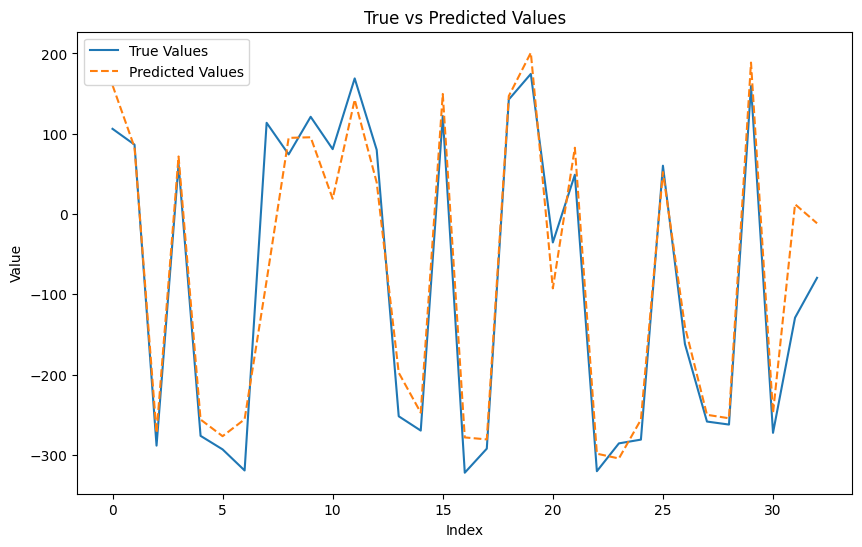

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


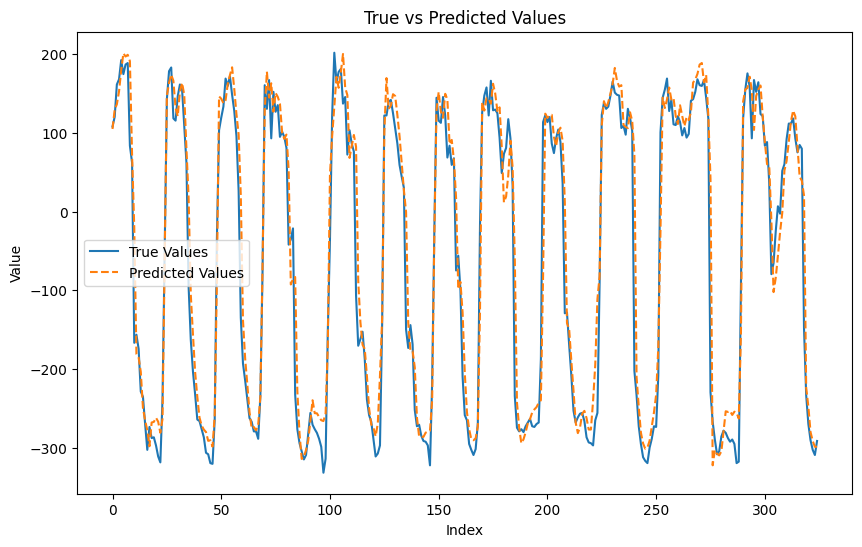

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


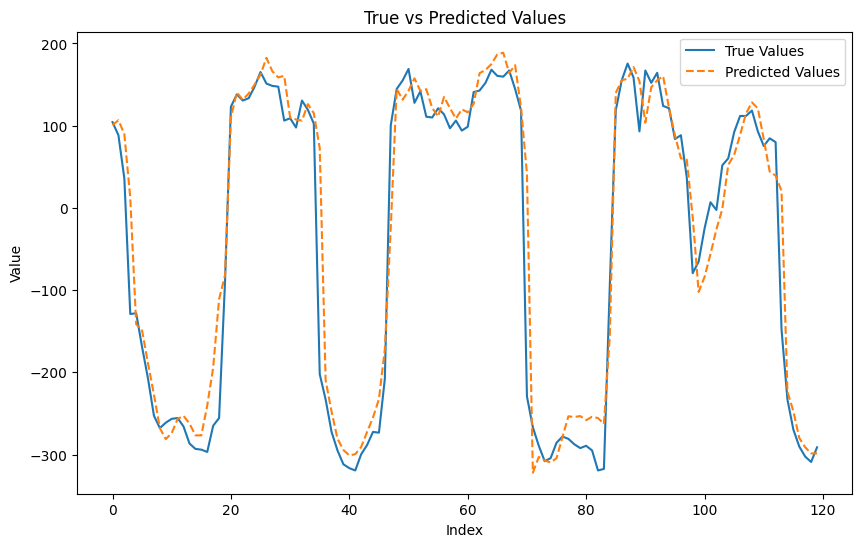

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


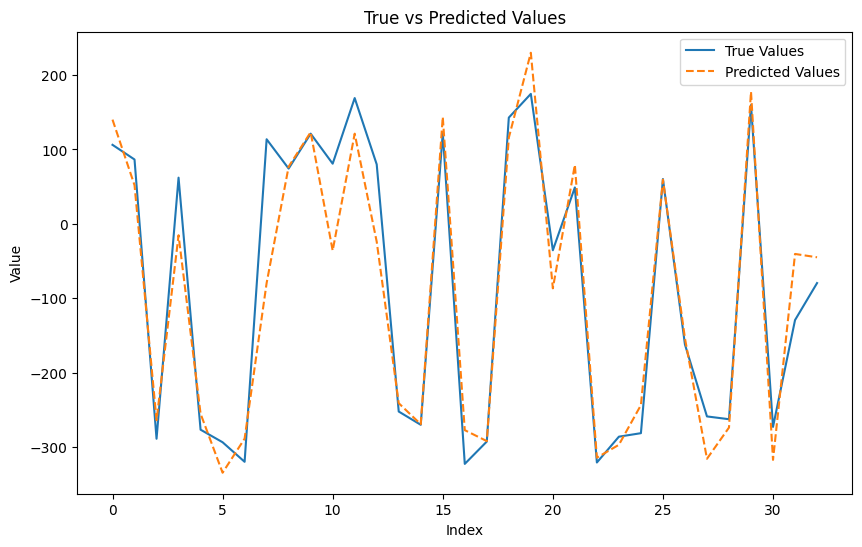

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


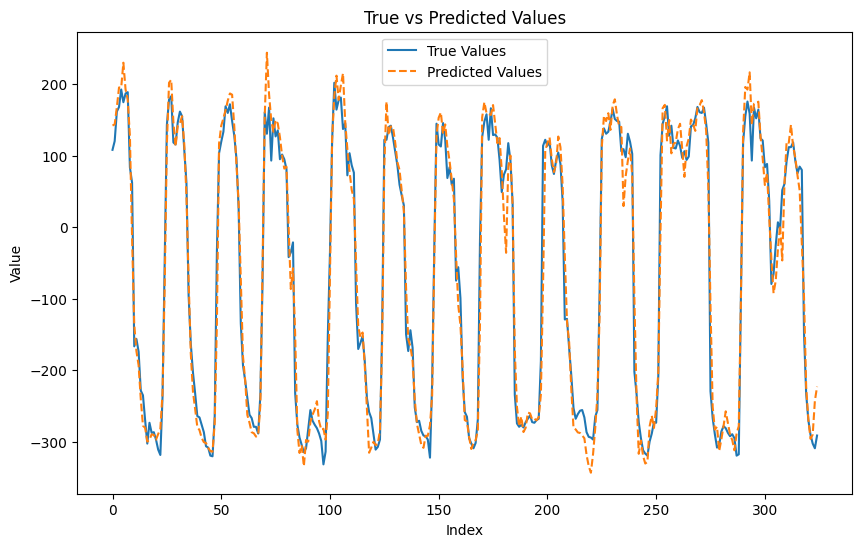

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


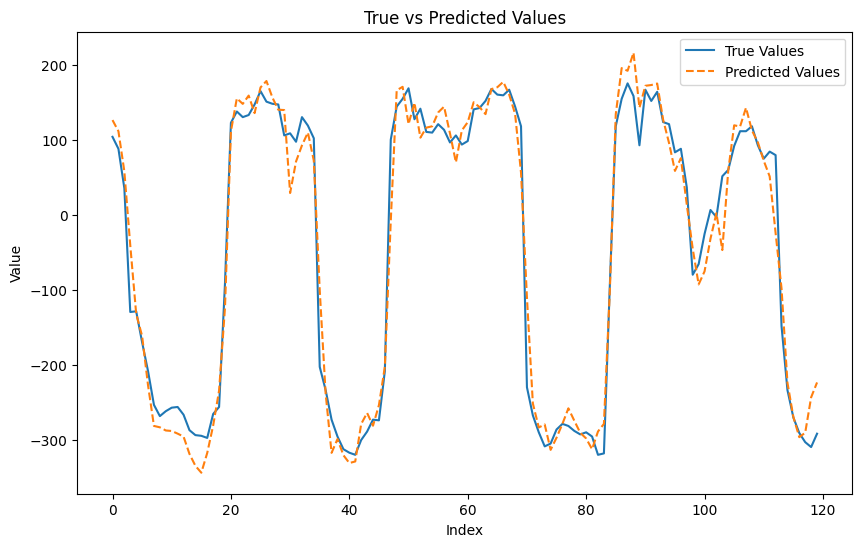

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [ ]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


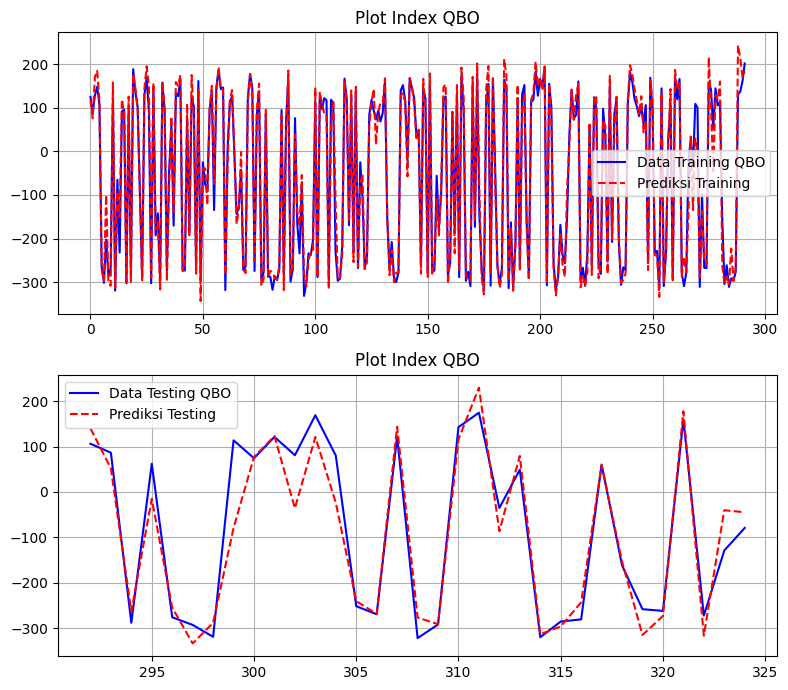

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.06580766078457863
RMSE:  0.25653003875682595
R-squared:  0.9342800946446729
MAE:  0.16276319230408492
Log Likelihood:  -200646.91994804097
MAPE:  171.76484380211144


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.032580605930118384
RMSE:  0.1805009859533138
R-squared:  0.9674628407601998
MAE:  0.12536362836463397
Log Likelihood:  -205006.38527571995
MAPE:  176.93938298092593


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.07957756730747004
RMSE:  0.28209496150670615
R-squared:  0.9189863210893214
MAE:  0.19448647499105273
Log Likelihood:  -2016.3141138932797
MAPE:  158.19327685620047


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.08711949102378336
RMSE:  0.29516011082763766
R-squared:  0.9113082906217467
MAE:  0.20734016869197341
Log Likelihood:  -2034.222281021888
MAPE:  160.2488251652422


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  2341.939215908658
RMSE:  48.3935865162798
R-squared:  0.9342800948894521
MAE:  30.704765714493217
Log Likelihood:  -380863.7776084485
MAPE:  33.168092914353565


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  1159.4668463412336
RMSE:  34.05094486708458
R-squared:  0.9674628399393334
MAE:  23.64945513042897
Log Likelihood:  -188712.017553742
MAPE:  24.769246631851065


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  2703.359533701167
RMSE:  51.99384130549662
R-squared:  0.9254967667967346
MAE:  30.182590210618596
Log Likelihood:  -162311.84464605458
MAPE:  37.819498619304476


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  1211.9526272423604
RMSE:  34.813109990955425
R-squared:  0.966599193302592
MAE:  25.334566629722737
Log Likelihood:  -72827.4302585262
MAPE:  26.682106161312248


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  2831.9776841402504
RMSE:  53.21632911184546
R-squared:  0.9189863208679326
MAE:  36.68926213799114
Log Likelihood:  -46757.95675990988
MAPE:  32.408470609583496
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  2286.5582449451895
RMSE:  47.81796989569078
R-squared:  0.9358649451340725
MAE:  30.02843537795425
Log Likelihood:  -334105.8338136935
MAPE:  33.253940309928765


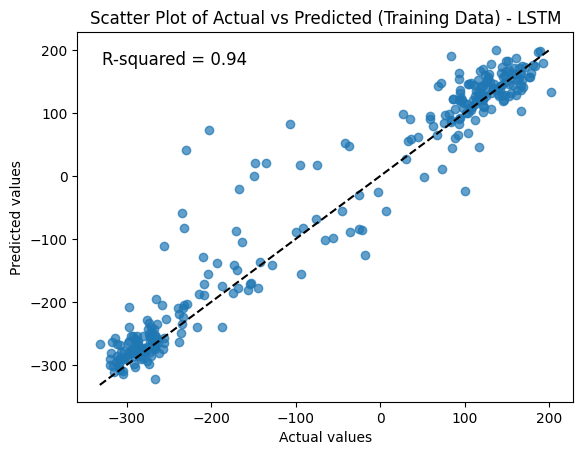

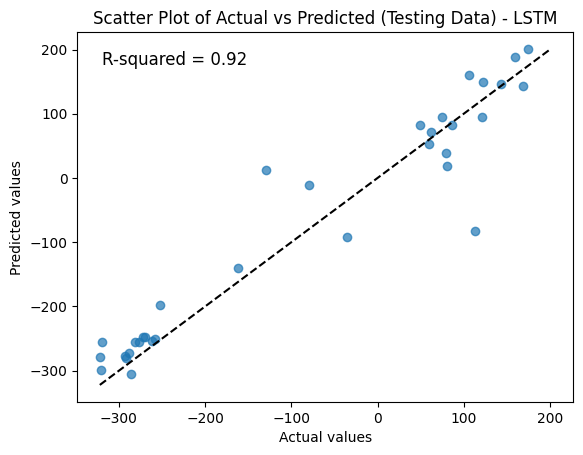

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  3100.3770557879266
RMSE:  55.681029586277646
R-squared:  0.911308286999345
MAE:  39.114072214480025
Log Likelihood:  -51186.54639209655
MAPE:  36.34483977713166
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  940.1173981203526
RMSE:  30.661333925978376
R-squared:  0.9736309009218757
MAE:  21.90174159505365
Log Likelihood:  -137525.47017726727
MAPE:  23.46104625958445


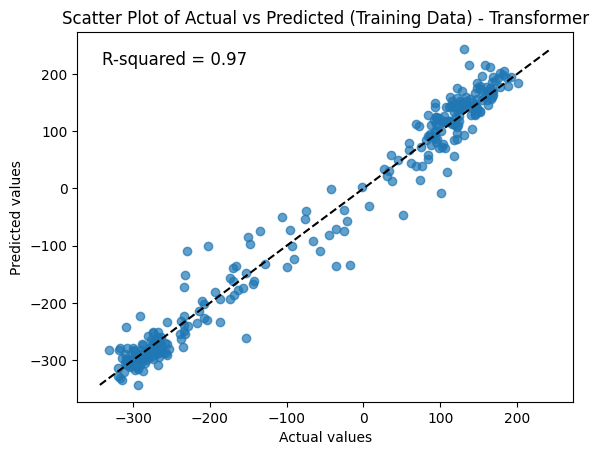

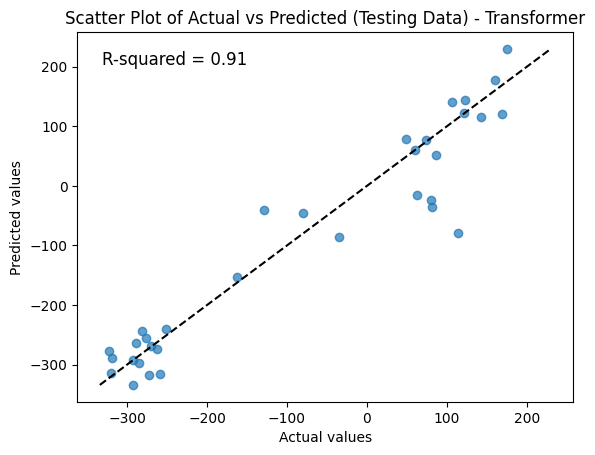

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

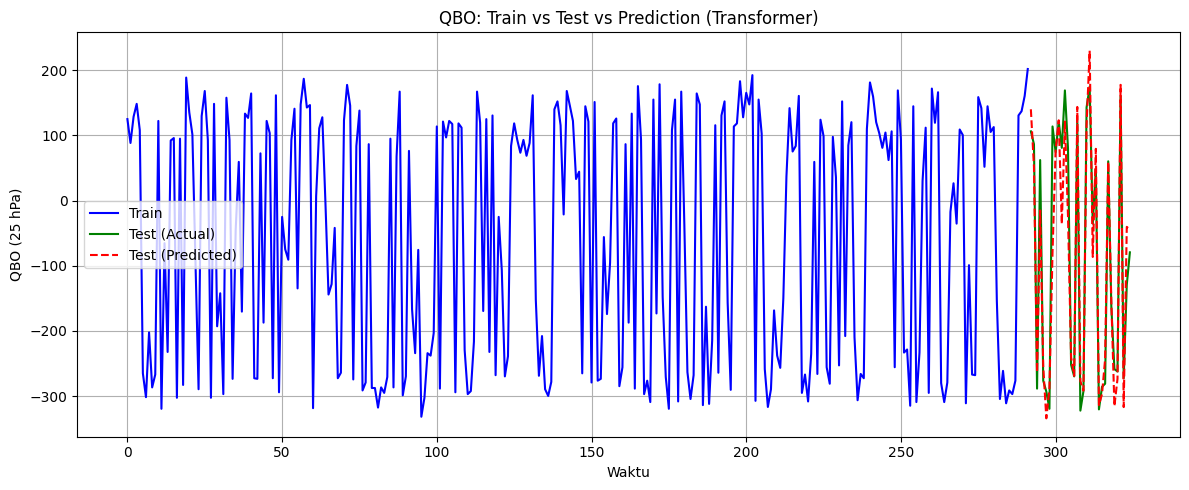

In [56]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

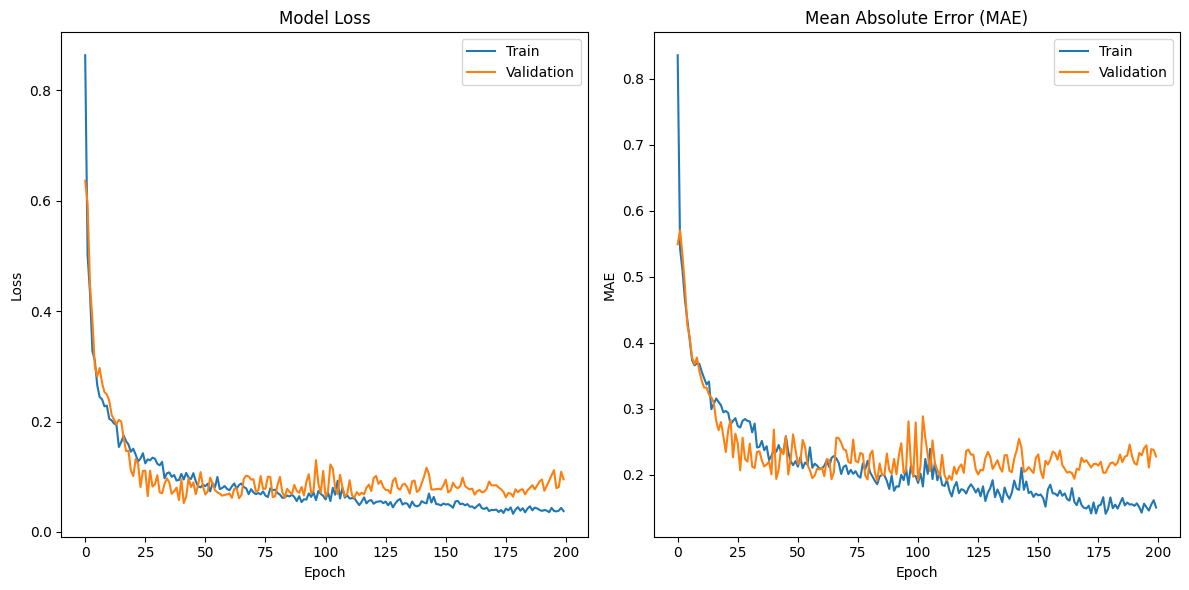

In [37]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [38]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

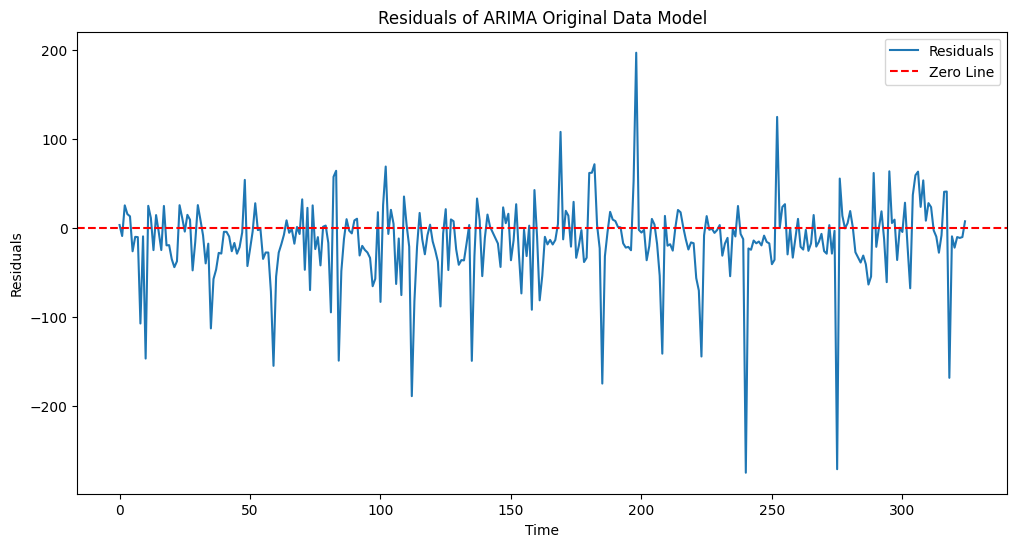

In [39]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

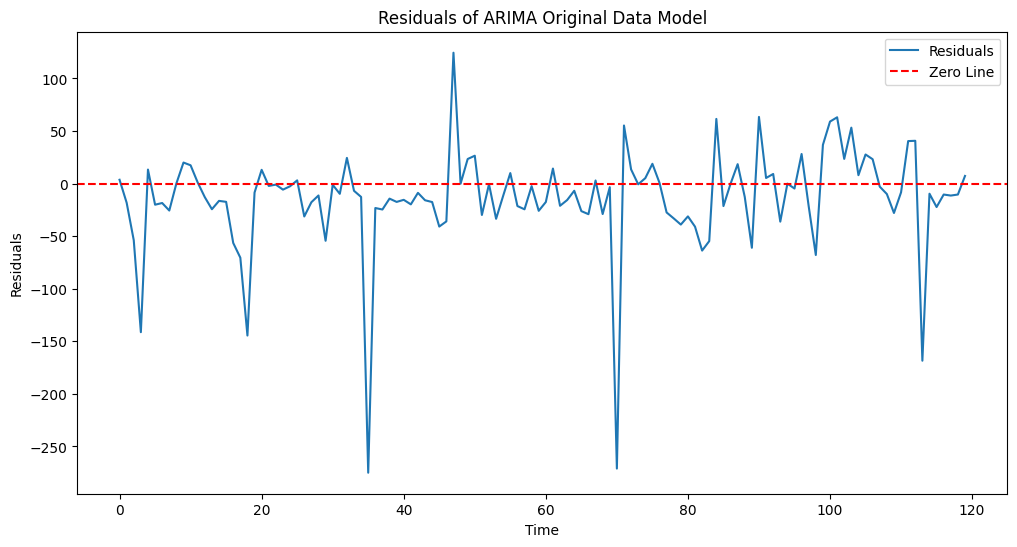

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [41]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

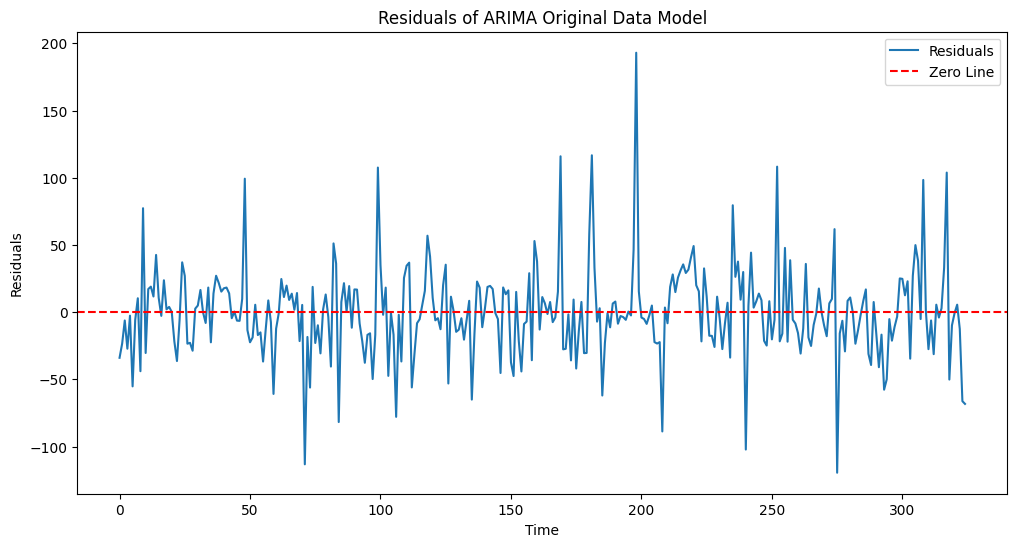

In [42]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

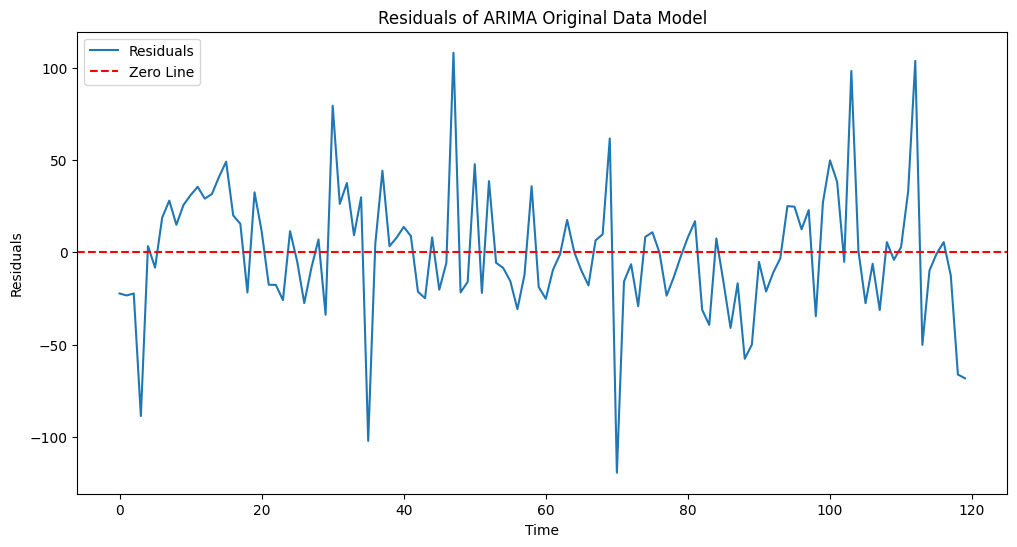

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [44]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8472093673638106
P-value: 2.7795210727010996e-17
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

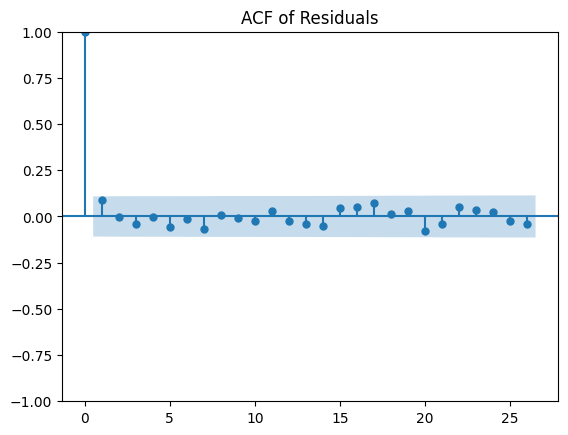

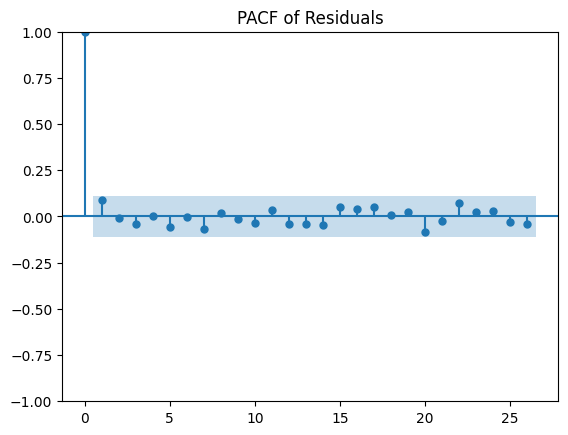

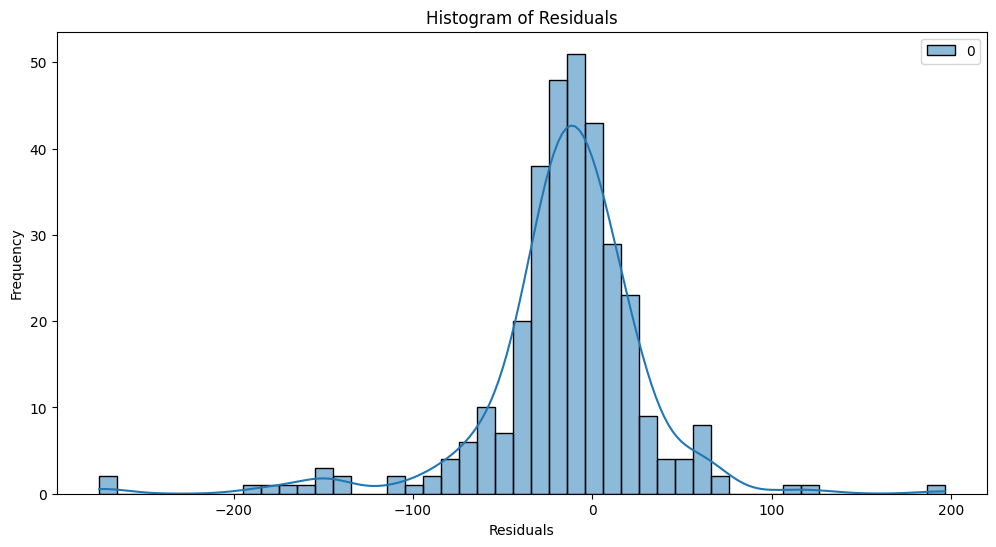

In [45]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.7543868768366816
P-value: 6.91326579251393e-13
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

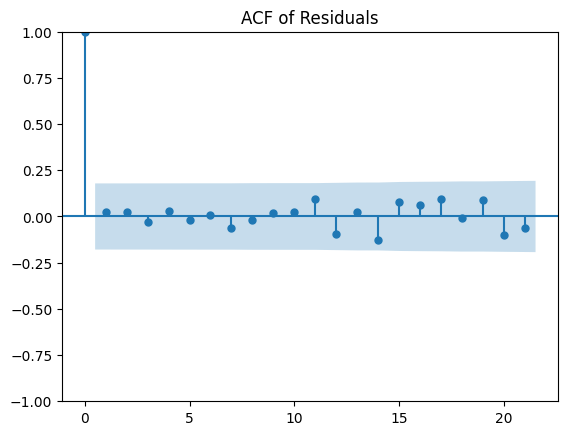

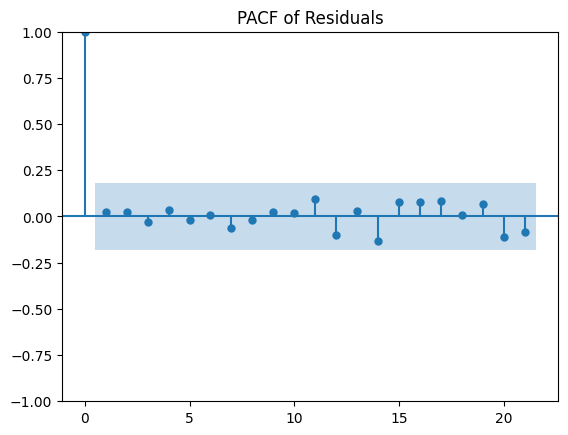

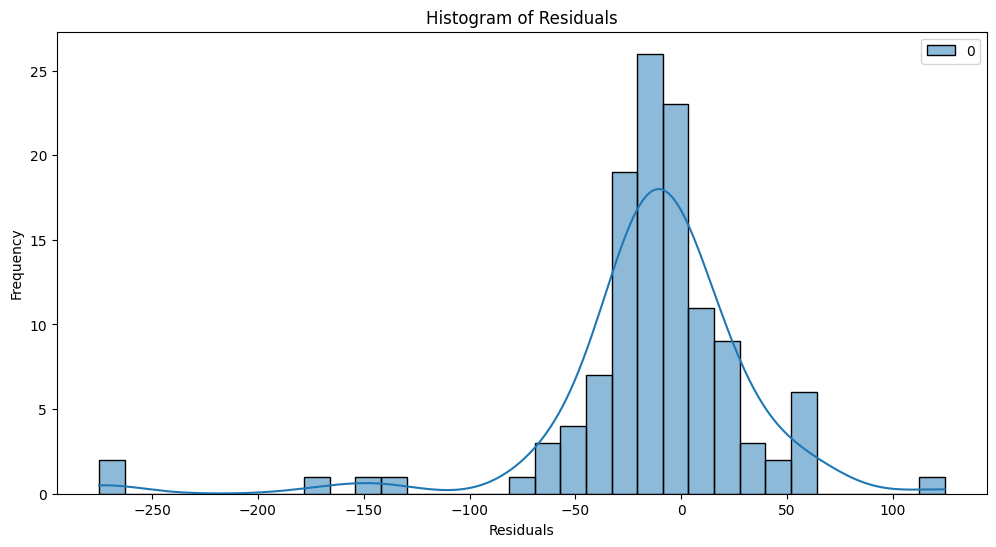

In [46]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9300916920761932
P-value: 3.248642320513607e-11
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

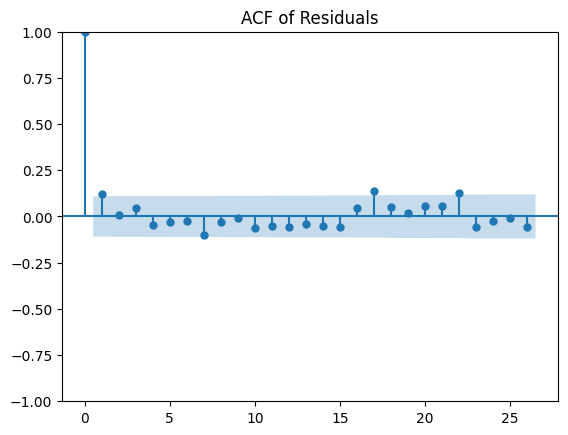

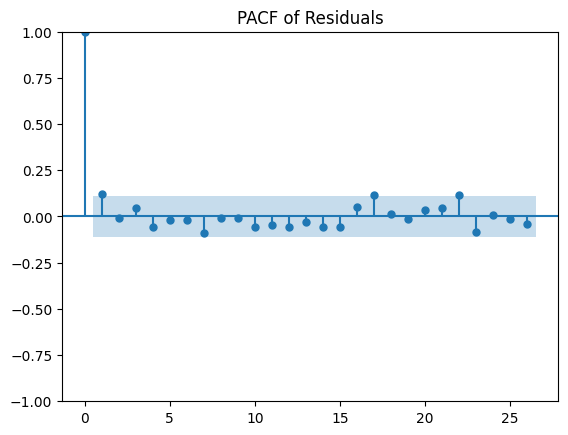

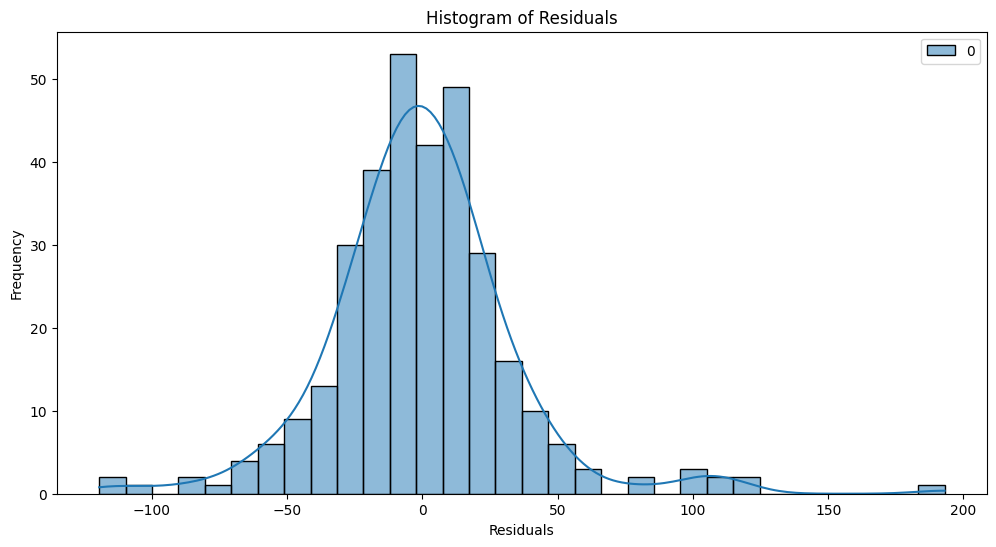

In [47]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9572960923403447
P-value: 0.0007720723602443578
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

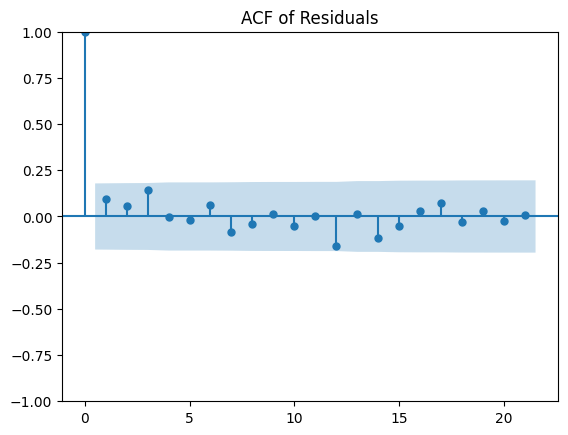

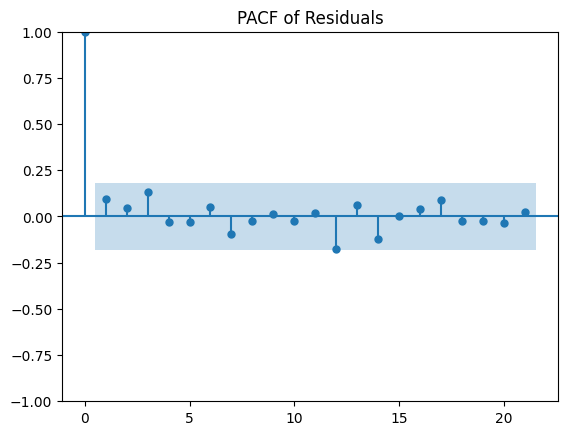

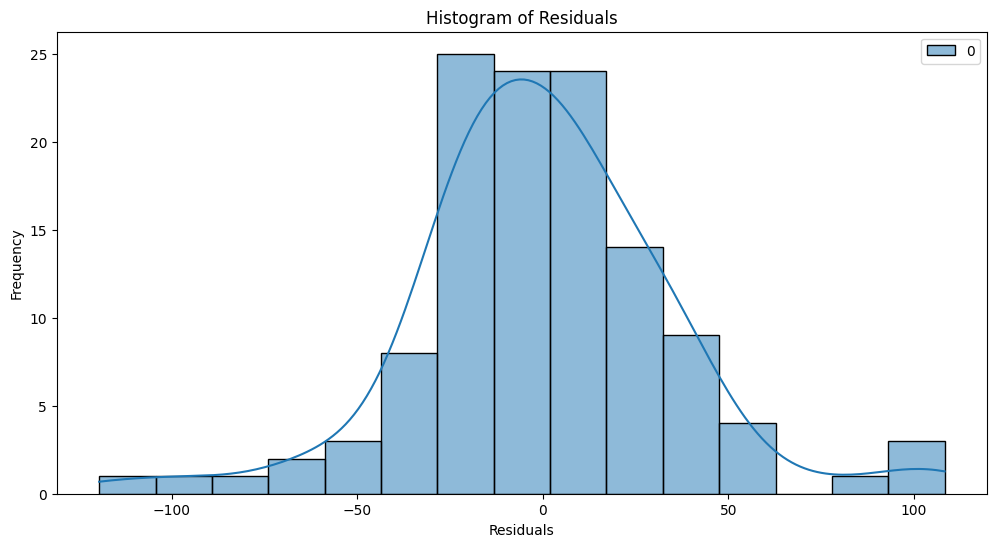

In [48]:
residual_analysis(residuals_final2)

In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dan atur data
data_df = pd.read_excel('QBO Data.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)
data_df = data_df[['25 hPa']]

In [50]:
# Fit ARIMA (bisa ubah order sesuai hasil AIC/BIC terbaik)
model_arima = ARIMA(data_df['25 hPa'], order=(4, 0, 5))  # Contoh order
model_fit = model_arima.fit()

# Prediksi in-sample
arima_pred = model_fit.fittedvalues

# Residual = aktual - prediksi
data_df['residual'] = data_df['25 hPa'] - arima_pred

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

In [51]:
# Gunakan residual sebagai target Transformer
target_col = 'residual'

# Tambahkan fitur seperti sebelumnya (gunakan data_df)
add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

# Drop NaN
data_df = data_df.dropna()

# Pisahkan input dan target
X = data_df.drop(columns=['25 hPa', 'residual'])
y = data_df['residual']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tambahkan dimensi time untuk Transformer
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  # shape: (samples, time, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

In [53]:
def build_transformer(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_transformer(X_train_scaled.shape[1:])  # input shape = (time, features)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 78)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      5,056 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1, 64)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train Transformer on residuals
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Prediksi residual
residual_pred = model.predict(X_test_scaled).flatten()

# Prediksi ARIMA untuk periode test
arima_forecast = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

# Kombinasi: ARIMA + Transformer
final_pred = arima_forecast + residual_pred

# Evaluasi
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test + arima_forecast, final_pred)))
print("R2 Score:", r2_score(y_test + arima_forecast, final_pred))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 2232.9688 - val_loss: 1356.5585
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1840.5132 - val_loss: 1334.2262
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2167.4202 - val_loss: 1308.2917
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2336.7004 - val_loss: 1254.9979
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1916.9176 - val_loss: 1179.0625
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1775.8683 - val_loss: 1130.0114
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1527.4485 - val_loss: 1025.7783
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1624.2500 - val_loss: 959.0415
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1450.2153 - val_loss: 850.5872
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1401.2704 - val_loss: 797.2227
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1308.1675 - val_loss: 748.5298
E

ValueError: operands could not be broadcast together with shapes (76,) (71,) 